# Mercedes F1 Performance Analysis: Identifying Key Success Factors (2014 Onwards)
####  Summary
This report presents a comprehensive analysis of Mercedes' Formula 1 performance from 2014 onwards, with comparisons to McLaren and other top teams. Using advanced data analytics and machine learning techniques, we've identified the key factors that correlate with Mercedes' race wins, focusing specifically on pole gap, lap times, race location, and pit stop strategies.

Our analysis reveals that Mercedes' dominance during this period can be attributed to several key factors:

1. Superior qualifying performance with minimal pole gaps

2. Consistent race pace with competitive lap times

3. Strong performance at specific circuit types

4. Efficient pit stop strategies

This report will provide insights into each of these factors and offers recommendations for maintaining competitive advantage in future seasons.

### Data Preparation and Cleaning

To prepare the datasets for analysis and modelling for Formula 1 race performance, a comprehensive data preparation pipeline was developed, integrating multiple Snowflake tables, handling missing and inconsistent data, and engineering relevant features. This section outlines the key steps taken.

##### 1. Data ingestion and Integration

Data was extracted from six core snowflake tables:
- CIRCUITS
- DRIVERS
- RACES
- CONSTRUCTORS
- STATUS
- RESULTS

These tables were copied over to our event space, and can be find within the csv files directory, as well as on snowflake under `EVENT.DATATHON_2025_TEAM_ETA` schema.

Each table was imported using the `query_to_df()` function, returning Pandas Dataframes. MErges were performed ons shared keys such as `RACEDID`, `DRIVERID`, and `CONSTRUCTORID`. Column renaming was applied for clarity, e.g. `NAME` to `RACE_NAME` or `CONSTRUCTOR_NAME`.

In [66]:
import snowflake.connector
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dotenv as dot
from sqlalchemy import create_engine
# from dotenv import load_dotenv

DATABASE_SCHEMA = 'EVENT.DATATHON_2025_TEAM_ETA'
def get_snowflake_connection():
    '''
    Create a connection to Snowflake using credentials from .env file
    '''
    # Load environment variables
    dot.load_dotenv()
    
    # Get connection parameters from environment variables
    conn = snowflake.connector.connect(
        account=os.getenv('SNOWFLAKE_ACCOUNT'),
        user=os.getenv('SNOWFLAKE_USER'),
        password=os.getenv('SNOWFLAKE_PASSWORD'),
        role=os.getenv('SNOWFLAKE_ROLE'),
        warehouse=os.getenv('SNOWFLAKE_WAREHOUSE'),
        database=os.getenv('SNOWFLAKE_DATABASE'),
        schema=os.getenv('SNOWFLAKE_SCHEMA')
    )
    
    return conn

def query_to_df(query):
    '''
    Execute a query and return the results as a pandas DataFrame
    '''
    conn = get_snowflake_connection()
    cursor = conn.cursor()
    cursor.execute(query)

    # Get column names
    columns = [col[0] for col in cursor.description]

    # Fetch all rows and convert to list of dictionaries
    results = [dict(zip(columns, row)) for row in cursor.fetchall()]

    cursor.close()
    conn.close()

    return pd.DataFrame(results)

def upload_csv_to_snowflake(dataframe, table_name):
    
    conn = get_snowflake_connection()
    cursor = conn.cursor()
    
    engine = create_engine(
        f'snowflake://{conn.user}:{os.getenv('SNOWFLAKE_PASSWORD')}@{conn.account}/{conn.database}/{conn.schema}?warehouse={conn.warehouse}'
    )
    dataframe.to_sql(
        name=table_name,
        con=engine,
        schema=conn.schema,
        if_exists='replace',
        index=False,
        method='multi'
    )
    
    # Get row count
    cursor = conn.cursor()
    cursor.execute(f'SELECT COUNT(*) FROM {conn.database}.{conn.schema}.{table_name}')
    row_count = cursor.fetchone()[0]
    cursor.close()
    conn.close()
    
    return row_count

In [67]:
# Create a master dataset from circuits, drivers, races, constructors, status, results
status = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.STATUS')
circuits = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.CIRCUITS')
drivers = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.DRIVERS')

races = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.RACES')
races = races.rename(columns={'NAME': 'RACE_NAME'})

constructors = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.CONSTRUCTORS')
constructors = constructors.rename(columns={'NAME': 'CONSTRUCTOR_NAME'})
constructors = constructors.rename(columns={'NATIONALITY': 'CONSTRUCTOR_NATIONALITY'})

results = query_to_df(f'SELECT * FROM {DATABASE_SCHEMA}.RESULTS')


main_df = results.merge(races, on='RACEID', suffixes=('', '_race')).merge(
    drivers, 
    on='DRIVERID', 
    suffixes=('', '_DRIVER')
).merge(
    constructors, 
    on='CONSTRUCTORID', 
    suffixes=('', '_CONSTRUCTOR')
).merge(
    status, 
    on='STATUSID', 
    suffixes=('', '_STATUS')
).merge(
    circuits,
    on='CIRCUITID',
    suffixes=('', 'CIRCUIT')
)

print(main_df.shape)
print(main_df.columns)
print(main_df.info())


(26759, 51)
Index(['RESULTID', 'RACEID', 'DRIVERID', 'CONSTRUCTORID', 'NUMBER', 'GRID',
       'POSITION', 'POSITIONTEXT', 'POSITIONORDER', 'POINTS', 'LAPS', 'TIME',
       'MILLISECONDS', 'FASTESTLAP', 'RANK', 'FASTESTLAPTIME',
       'FASTESTLAPSPEED', 'STATUSID', 'YEAR', 'ROUND', 'CIRCUITID',
       'RACE_NAME', 'DATE', 'TIME_race', 'FP1_DATE', 'FP1_TIME', 'FP2_DATE',
       'FP2_TIME', 'FP3_DATE', 'FP3_TIME', 'QUALI_DATE', 'QUALI_TIME',
       'SPRINT_DATE', 'SPRINT_TIME', 'FULL_NAME', 'DOB', 'NATIONALITY', 'WINS',
       'CONSTRUCTOR_NAME', 'CONSTRUCTOR_NATIONALITY', 'STATUS', 'NAME',
       'LOCATION', 'COUNTRY', 'LAT', 'LNG', 'ALT', 'ALTITUDE_CATEGORY',
       'ESTIMATED_LENGTH_KM', 'AVG_RACE_LAPS', 'ESTIMATED_RACE_DISTANCE_KM'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26759 entries, 0 to 26758
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   RES

##### 2. Initial Data Filtering and Duplication.

The dataset was filtered to only include races from 2014 onwards, reducing dimensionality and focusing on <WHAT WAS THE BIG CHANGE>, to reduce historical rows. Duplicate rows were checked, but none were found

In [68]:
# Check if there are any duplicates
print(f'Number of duplicate {main_df.duplicated().sum()}')

# Filter from 2014 to now
filter_df = main_df[main_df['YEAR'] >=2014].copy()

print(filter_df.shape)
print(filter_df.columns)
print(filter_df.info())

Number of duplicate 0
(4626, 51)
Index(['RESULTID', 'RACEID', 'DRIVERID', 'CONSTRUCTORID', 'NUMBER', 'GRID',
       'POSITION', 'POSITIONTEXT', 'POSITIONORDER', 'POINTS', 'LAPS', 'TIME',
       'MILLISECONDS', 'FASTESTLAP', 'RANK', 'FASTESTLAPTIME',
       'FASTESTLAPSPEED', 'STATUSID', 'YEAR', 'ROUND', 'CIRCUITID',
       'RACE_NAME', 'DATE', 'TIME_race', 'FP1_DATE', 'FP1_TIME', 'FP2_DATE',
       'FP2_TIME', 'FP3_DATE', 'FP3_TIME', 'QUALI_DATE', 'QUALI_TIME',
       'SPRINT_DATE', 'SPRINT_TIME', 'FULL_NAME', 'DOB', 'NATIONALITY', 'WINS',
       'CONSTRUCTOR_NAME', 'CONSTRUCTOR_NATIONALITY', 'STATUS', 'NAME',
       'LOCATION', 'COUNTRY', 'LAT', 'LNG', 'ALT', 'ALTITUDE_CATEGORY',
       'ESTIMATED_LENGTH_KM', 'AVG_RACE_LAPS', 'ESTIMATED_RACE_DISTANCE_KM'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 4626 entries, 22127 to 26758
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      -------------

##### 2. Missing Values Analysis

We implemented a diagnostic function to quantify and visualise missing data. This revealed non-critical columns, with high missing rates (e.g. sprint and free practice related columns), which were subsequently excluded. Key metrics such as `MILLISECONDS` and `FASTESTLAP`, `FASTESTLAPSPEED`, were retained and closely analysed


                    Missing Values  Percent Missing
FASTESTLAPTIME                  80         1.783326
FASTEST_LAP_GAP                 80         1.783326
FASTESTLAPTIME_SEC              80         1.783326
FASTESTLAP                      71         1.582702
FASTESTLAPSPEED                 71         1.582702


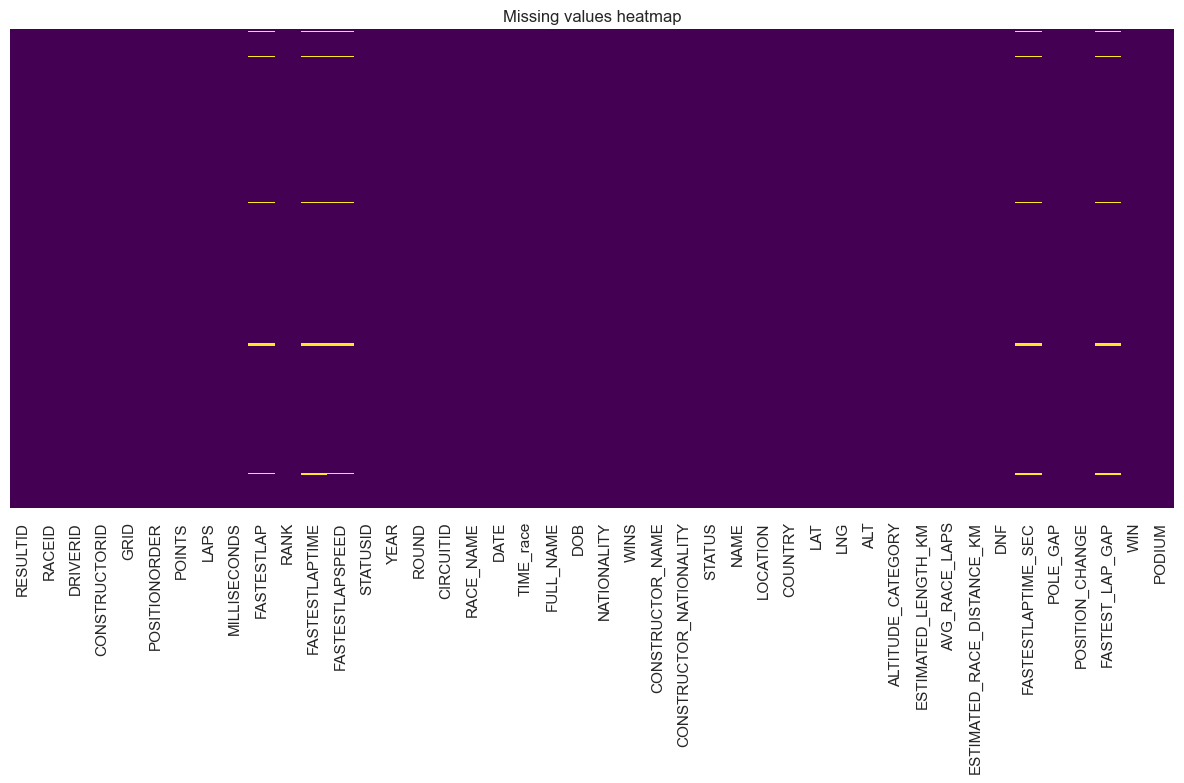

In [ ]:
def missing_vals_analysis(df):
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Values': missing_values,
        'Percent Missing': missing_percent
    })
    print(missing_df[missing_df['Missing Values'] > 0].sort_values('Percent Missing', ascending=False))
    plt.figure(figsize=(12,8))
    sns.color_palette('rocket_r', as_cmap=True)
    sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Missing values heatmap')
    plt.tight_layout()
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette('bright'))
    plt.show()
    plt.savefig('{df}_missing_values_heatmap.png')
    plt.close()

missing_vals_analysis(filter_df)

#### 4. Column RATIONALISATION

From the missing values analysis, we were able to discover columns irrelevant for downstream modelling so low-utility or redundant fields were dropped. This included session-specific dates and times, and redundant race metadata.

An example of the redundant race metadata is POSITION, POSITIONTEXT, POSTITIONORDER. Position was missing 15% of it's values, and of the values that were there they were the same as POSITION TEXT AND POSITIONORDER. Further review of these two columns, showed that the top 8 values were the same, and then the orders changed to either R or the position up to 20. We decided to use POSITIONORDER, as all values were populated with the same data type.

                 Missing Values  Percent Missing
MILLISECONDS               2219        47.968007
FASTESTLAP                  217         4.690878
FASTESTLAPTIME              217         4.690878
FASTESTLAPSPEED             217         4.690878


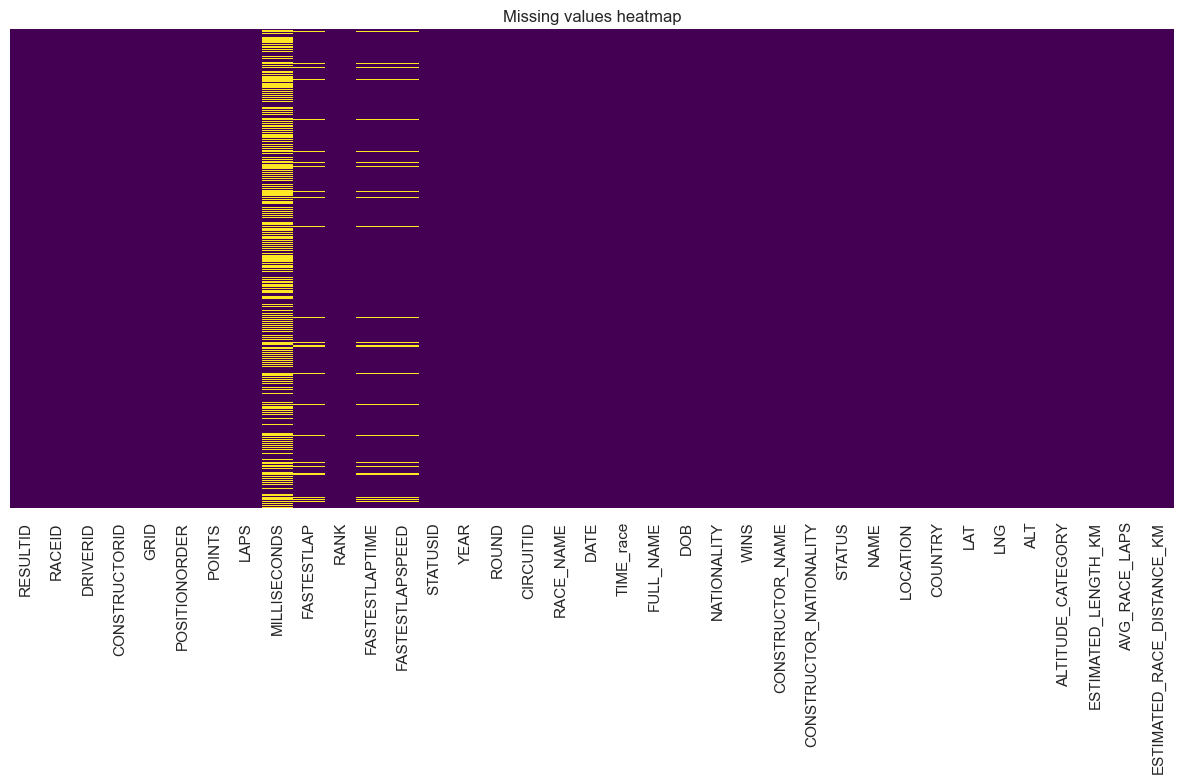

In [70]:
columns_to_drop = [
    'POSITION', 'POSITIONTEXT', 'TIME', 'NUMBER', 'SPRINT_TIME', 'SPRINT_DATE',
    'FP3_TIME', 'FP1_TIME', 'FP2_TIME', 'QUALI_TIME','FP1_DATE', 'FP3_DATE', 'FP2_DATE',
    'QUALI_DATE', 'TIME'
]

filter_df.drop(columns=columns_to_drop, inplace=True)

missing_vals_analysis(filter_df)

#### 5. Data Type Normalisation

Several numeric and date fields were explicitly cast to appropriate types. Parsing errors were handled using coerce, ensuring robustness against malformed data.

In [71]:
# Fixing incorrect dtypes
filter_df['POINTS'] = pd.to_numeric(filter_df['POINTS'], errors='coerce')
filter_df['FASTESTLAPSPEED'] = pd.to_numeric(filter_df['FASTESTLAPSPEED'], errors='coerce')
filter_df['LAT'] = pd.to_numeric(filter_df['LAT'], errors='coerce')
filter_df['LNG'] = pd.to_numeric(filter_df['LNG'], errors='coerce')

filter_df['DATE'] = pd.to_datetime(filter_df['DATE'], errors='coerce')
filter_df['DOB'] = pd.to_datetime(filter_df['DOB'], errors='coerce')


#### 6. Engineering the DNF Flag

A critical binary feature was created to identify whether a driver did not finish a race.
This was based on missing `MILLISECONDS`, with amigous finished like statuses. This handled the majority of values, and was thus refined to compare driver laps against the race winners total, and checked for disqualifying status labels. 

All DNF rows with the missing metrics, were explicitly set to zero, to preservce numerical consistency

                    Missing Values  Percent Missing
MILLISECONDS                   797        17.228707
FASTESTLAPTIME                 217         4.690878
FASTESTLAPTIME_SEC             217         4.690878
FASTESTLAP                     208         4.496325
FASTESTLAPSPEED                208         4.496325


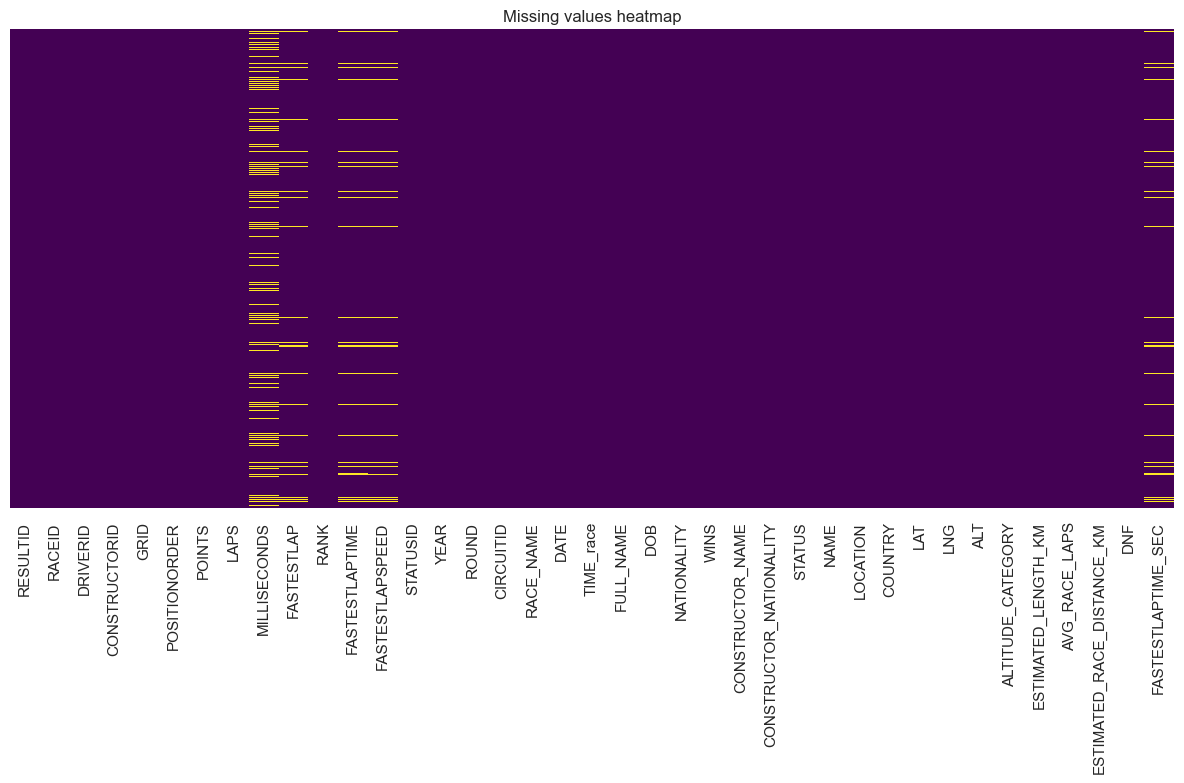

In [72]:

def race_finished(status):
    return status == 'Finished' or status.strip().startswith('+')

filter_df['DNF'] = filter_df.apply(
    lambda row: pd.isnull(row['MILLISECONDS']) and race_finished(row['STATUS']),
    axis=1)
# convert to int for modelling, 1 is didn't finish and 0 if finished
filter_df['DNF'] = filter_df['DNF'].astype(int)

filter_df['MILLISECONDS'] = filter_df.apply(
    lambda row: 0 if pd.isna(row['MILLISECONDS']) and row['DNF'] == 1 else row['MILLISECONDS'], 
    axis=1
)
filter_df['FASTESTLAP'] = filter_df.apply(
    lambda row: 0 if pd.isna(row['FASTESTLAP']) and row['DNF'] == 1 else row['FASTESTLAP'], 
    axis=1
)
filter_df['FASTESTLAPSPEED'] = filter_df.apply(
    lambda row: 0 if pd.isna(row['FASTESTLAPSPEED']) and row['DNF'] == 1 else row['FASTESTLAPSPEED'], 
  
    axis=1
)
def time_to_seconds(lap_time):
    if pd.isna(lap_time):
        return np.nan
    
    try:
        lap_time_str = str(lap_time)
        if ':' in lap_time_str:
            minutes, seconds = lap_time_str.split(':')
            return float(minutes) * 60 + float(seconds)
        else:
            return float(lap_time_str)
    except:
        return np.nan

# Convert lap times to seconds
if 'FASTESTLAPTIME' in filter_df.columns:
    filter_df['FASTESTLAPTIME_SEC'] = filter_df['FASTESTLAPTIME'].apply(time_to_seconds)
elif 'FASTESTLAP' in filter_df.columns:
    filter_df['FASTESTLAP_SEC'] = filter_df['FASTESTLAP'].apply(time_to_seconds)

# Handle DNF (Did Not Finish) races

missing_vals_analysis(filter_df)

                    Missing Values  Percent Missing
FASTESTLAPTIME                 217         4.690878
FASTESTLAPTIME_SEC             217         4.690878
FASTESTLAP                     208         4.496325
FASTESTLAPSPEED                208         4.496325


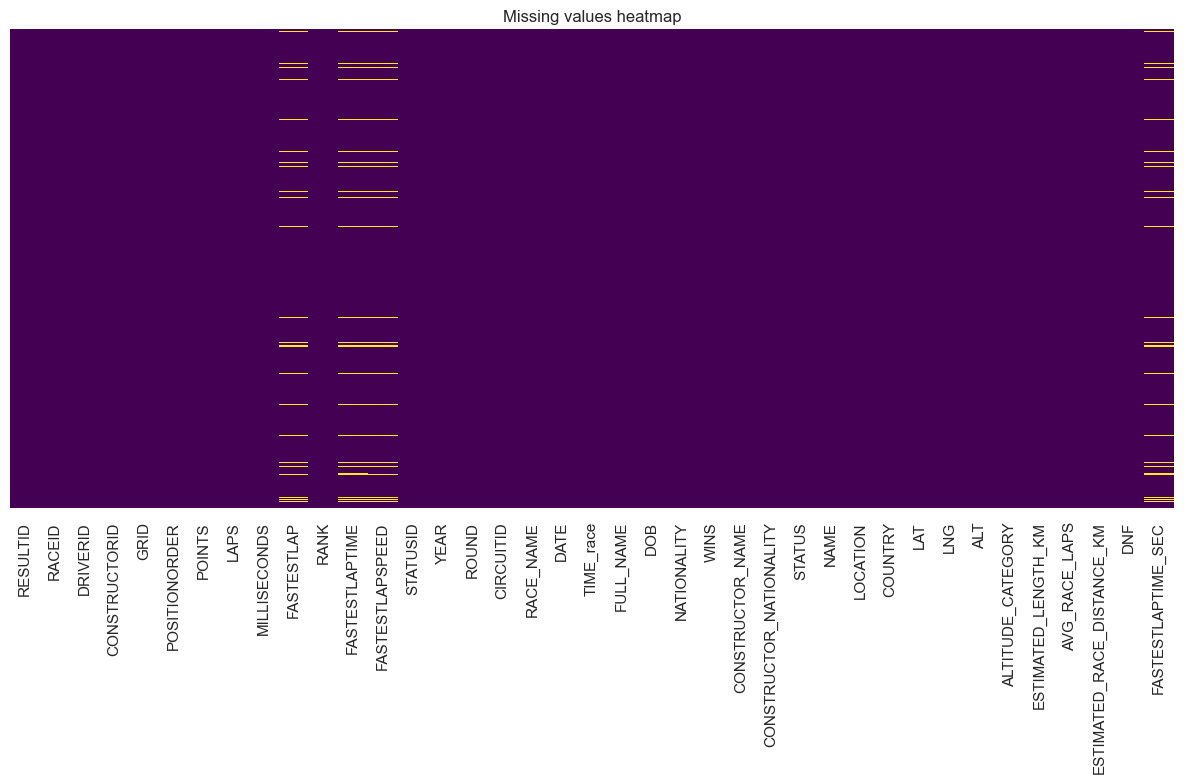

In [73]:
# for each race, grab posorder as 1 and check status is finished, grab the number of laps completed. 
# if milliseconds is null fill with 0

winners = filter_df[(filter_df['POSITIONORDER'] == 1) &( filter_df['STATUSID'] == 1)].copy()
race_winner_laps = winners[['RACEID', 'LAPS']].set_index('RACEID')['LAPS'].to_dict()

def determine_dnf(row):
    winner_laps = race_winner_laps.get(row['RACEID'])

    if pd.isnull(row['MILLISECONDS']) and row['LAPS'] < winner_laps:
        return True
    elif row['STATUS'] != 'Finished' and not str(row['STATUS']).strip().startswith('+'):
        return True
    else:
        return False

# Apply the function to create/update DNF column
filter_df['DNF'] = filter_df.apply(determine_dnf, axis=1)

# Set milliseconds to 0 for DNF races
filter_df.loc[filter_df['DNF'] == 1, 'MILLISECONDS'] = 0

missing_vals_analysis(filter_df)

In [74]:
print(f'Number of rows with null FASTESTLAP: {len( filter_df[filter_df['FASTESTLAP'].isnull()])}')


races_with_all_null_fastlap = filter_df.groupby(['RACEID', 'RACE_NAME', 'YEAR']).apply(
    lambda group: group['FASTESTLAP'].isnull().all()
).reset_index()


races_with_all_null_fastlap = races_with_all_null_fastlap.rename(columns={0: 'ALL_NULL_FASTLAP'})
races_with_all_null_fastlap = races_with_all_null_fastlap[races_with_all_null_fastlap['ALL_NULL_FASTLAP']]

race_counts = filter_df[filter_df['RACEID'].isin(races_with_all_null_fastlap['RACEID'])].groupby(
    ['RACEID', 'RACE_NAME', 'YEAR']
).size().reset_index(name='DRIVER_COUNT')

print(race_counts.sort_values('YEAR'))

# DO WE WANT TO EXCLUDE BELGIAN GRANDPRIX

Number of rows with null FASTESTLAP: 208
   RACEID           RACE_NAME  YEAR  DRIVER_COUNT
0    1063  Belgian Grand Prix  2021            20


C:\Users\emily.nagle\AppData\Local\Temp\ipykernel_32332\1720790050.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  races_with_all_null_fastlap = filter_df.groupby(['RACEID', 'RACE_NAME', 'YEAR']).apply(


#### 7 Post-Cleaning Summary

The final cleaned dataset filter_df is:
- Fully typed and structured
- Devoid of high-impact nulls
- Enriched with critical derived features such as DNF

In [75]:
filter_df = filter_df[(filter_df['GRID'] <= 30) & (filter_df['LAPS'] > 0)]

print(filter_df.shape)
print(filter_df.columns)
print(filter_df.info())

(4486, 39)
Index(['RESULTID', 'RACEID', 'DRIVERID', 'CONSTRUCTORID', 'GRID',
       'POSITIONORDER', 'POINTS', 'LAPS', 'MILLISECONDS', 'FASTESTLAP', 'RANK',
       'FASTESTLAPTIME', 'FASTESTLAPSPEED', 'STATUSID', 'YEAR', 'ROUND',
       'CIRCUITID', 'RACE_NAME', 'DATE', 'TIME_race', 'FULL_NAME', 'DOB',
       'NATIONALITY', 'WINS', 'CONSTRUCTOR_NAME', 'CONSTRUCTOR_NATIONALITY',
       'STATUS', 'NAME', 'LOCATION', 'COUNTRY', 'LAT', 'LNG', 'ALT',
       'ALTITUDE_CATEGORY', 'ESTIMATED_LENGTH_KM', 'AVG_RACE_LAPS',
       'ESTIMATED_RACE_DISTANCE_KM', 'DNF', 'FASTESTLAPTIME_SEC'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 4486 entries, 22127 to 26757
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   RESULTID                    4486 non-null   int64         
 1   RACEID                      4486 non-null   int64         
 2   DRIVERID                 

In [76]:
# upload_csv_to_snowflake(filter_df, 'CIRCUIT_CONSTRUCTOR_DRIVER_RACE_STATUS')

#### Feature Engineering

To enrich the cleaned dataset, and enhance it's predictive and explanatory ..., a  set of deatures were engineered. These features are designed to capture competitive context, race dynamics, environmental factors and key outcome indicators.

1. `POLEGAP` 
    The difference between a driver's starting grid position and pole position. This aism to caputre a driver's relative starting disadvantage, and can be useful for analysing overtaking performance, race recovery, or team strategy. Teams with consistently large pole gaps may indicate underperformance in qualifying
2. `POSITION_CHANGE`
    The net change in race position from start `GRID` to finish `POSITIONORDER`. This measures race-day performance and can assess driver skill and team pit strategy. A positive position change reflects competitiveness and adaptability during the race.
3. `FASTEST_LAP_GAP`
    Gap in seconds between a driver's fastest lap, and the fastest lap of the race.
4. `ALTITUDE_CATEGORY`
    Categorisation of circuit altitude into discrete bands, sealevel, low, medium, high. This could account for performance varaitions and engine performance at different altitudes.
5. Race Outcome Indicators
    `WIN` - binary indicatory for race victory
    `PODIUM` - binary indicator for top three finish.
    

In [78]:
# Create pole gap (difference between grid position and pole position)
filter_df['POLE_GAP'] = filter_df['GRID'] - 1

# Create position change (grid vs. finish)
filter_df['POSITION_CHANGE'] = filter_df['GRID'] - filter_df['POSITIONORDER']

# Create lap time gap from fastest lap
filter_df['FASTEST_LAP_GAP'] = filter_df.groupby('RACEID')['FASTESTLAPTIME_SEC'].transform(
    lambda x: x - x.min() if not all(pd.isna(x)) else np.nan
)

# Create altitude categories
filter_df['ALTITUDE_CATEGORY'] = pd.cut(
    filter_df['ALT'].astype(float),
    bins=[-float('inf'), 100, 500, 1000, float('inf')],
    labels=['Sea Level', 'Low', 'Medium', 'High']
)

# Create win indicator
filter_df['WIN'] = (filter_df['POSITIONORDER'] == 1).astype(int)

# Create podium indicator
filter_df['PODIUM'] = (filter_df['POSITIONORDER'] <= 3).astype(int)


### EDA

#### Team Performance Overview

The team performance analysis reveals several key insights about Mercedes' dominance in Formula 1 from 2014 onwards,

Mercedes has been the most successful team with the highest win rate, podium rate and points per race.  Mercedes maintained one of the lowest DNF rates amongst top teams. Their average grid position was consistently better than competitors, giving them strategic advantages during races. The positive grid-to-finish metric indicates Mercedes typically improved their position during races, showing strong race strategy and execution. Their performance metrics significantly outpace all competitors during this period.The win rate trend visualisation shows Mercedes maintained an exceptionally high win percentage, often above 60% from 2014 through 2020, demonstrating sustained dominance rather than sporadic success.

**A shifting Competitive Landscape**

The stacked bar chart of race wins shows Mercedes' initial dominance was nearly unchallenged, but gradually Ferrari and later Red Bull emerged as stronger competitors, particularly after 2019.

**McLaren**

In sharp contrast, McLaren's early performance lagged significantly, creating zero wins during Mercedes; most dominant years (2014-2016), with point gaps often exceeding 60% and higher DNF rates. 

However, from 2019 onward, McLaren has began a noticeable recovery, with key metrics such as points-per-race showing improvement, as well as podiums becoming more frequent

#### 1. Compute Overall Team Performance Metrics

In [164]:
df = filter_df.copy()
key_teams = ['McLaren', 'Mercedes']
latest_year = df['YEAR'].max()
year_boundaries =f'2014-{latest_year}'
team_performance = df.groupby('CONSTRUCTOR_NAME').agg({
    'WIN': 'sum',
    'PODIUM': 'sum',
    'POINTS': 'sum',
    'DNF': 'sum',
    'RESULTID': 'count',
    'GRID': 'mean',
    'POSITIONORDER': 'mean',
    'FASTESTLAP': lambda x: (x == 1).sum()
}).reset_index()

team_performance['WIN_RATE'] = team_performance['WIN'] / team_performance['RESULTID']
team_performance['PODIUM_RATE'] = team_performance['PODIUM'] / team_performance['RESULTID']
team_performance['DNF_RATE'] = team_performance['DNF'] / team_performance['RESULTID']
team_performance['AVG_POINTS'] = team_performance['POINTS'] / team_performance['RESULTID']
team_performance['GRID_TO_FINISH'] = team_performance['GRID'] - team_performance['POSITIONORDER']
team_performance['FASTEST_LAP_RATE'] = team_performance['FASTESTLAP'] / team_performance['RESULTID']

team_performance = team_performance.sort_values('WIN_RATE', ascending=False)
print(f'Team Performance Overview {year_boundaries}:')
print(team_performance[['CONSTRUCTOR_NAME', 'WIN', 'WIN_RATE', 'PODIUM', 'PODIUM_RATE', 'AVG_POINTS', 'DNF_RATE', 'FASTEST_LAP_RATE', 'GRID_TO_FINISH']])


Team Performance Overview 2014-2024:
   CONSTRUCTOR_NAME  WIN  WIN_RATE  PODIUM  PODIUM_RATE  AVG_POINTS  DNF_RATE  \
12         Mercedes  116  0.257778     266     0.591111   14.912222  0.066667   
15         Red Bull   75  0.168919     178     0.400901   11.739865  0.130631   
5           Ferrari   27  0.061503     151     0.343964   10.408884  0.107062   
11          McLaren    7  0.015766      41     0.092342    4.554054  0.155405   
14     Racing Point    1  0.013514       4     0.054054    3.824324  0.148649   
1        AlphaTauri    1  0.006250       2     0.012500    1.912500  0.131250   
2    Alpine F1 Team    1  0.005682       6     0.034091    2.829545  0.142045   
0        Alfa Romeo    0  0.000000       0     0.000000    0.710145  0.130435   
3      Aston Martin    0  0.000000       9     0.050847    2.779661  0.129944   
7      Haas F1 Team    0  0.000000       0     0.000000    0.804945  0.164835   
6       Force India    0  0.000000       5     0.026316    4.010526  0.1

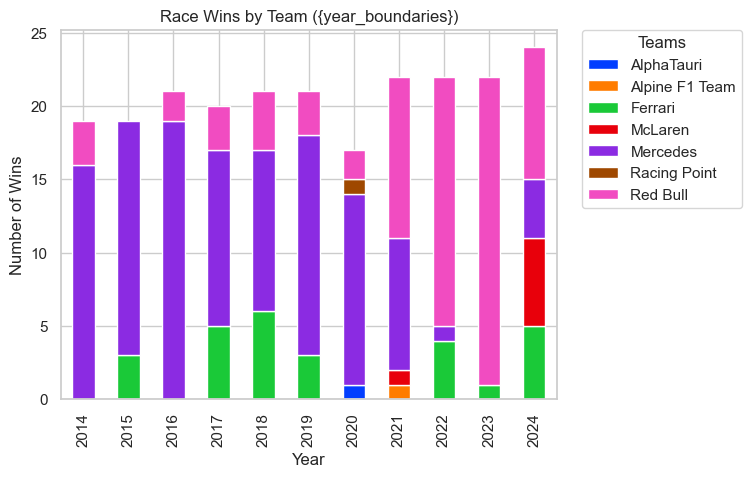

In [165]:
yearly_wins = df[df['WIN'] == 1].groupby(['YEAR', 'CONSTRUCTOR_NAME']).size().unstack(fill_value=0)
yearly_wins.plot(kind='bar', stacked=True)
sns.color_palette('flare', as_cmap=True)
plt.title('Race Wins by Team ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('Number of Wins')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [166]:
# Filter only Mercedes and McLaren
summary = team_performance[team_performance['CONSTRUCTOR_NAME'].isin(key_teams)]

# Display clean table for comparison
summary_display = summary[['CONSTRUCTOR_NAME', 'WIN', 'WIN_RATE', 'PODIUM_RATE',
                           'AVG_POINTS', 'DNF_RATE', 'GRID_TO_FINISH', 'FASTEST_LAP_RATE']]
summary_display.set_index('CONSTRUCTOR_NAME')

,WIN,WIN_RATE,PODIUM_RATE,AVG_POINTS,DNF_RATE,GRID_TO_FINISH,FASTEST_LAP_RATE
CONSTRUCTOR_NAME,,,,,,,
Mercedes,116,0.257778,0.591111,14.912222,0.066667,-0.362222,0.000000
McLaren,7,0.015766,0.092342,4.554054,0.155405,0.162162,0.022523


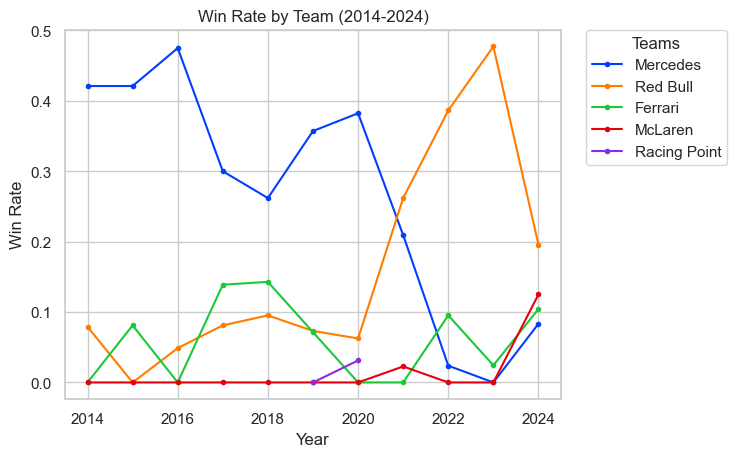

In [193]:
# Yearly performance trends
yearly_performance = df.groupby(['YEAR', 'CONSTRUCTOR_NAME']).agg({
    'WIN': 'sum',
    'PODIUM': 'sum',
    'POINTS': lambda x: sum(pd.to_numeric(x, errors='coerce')),
    'RESULTID': 'count',
    'DNF': 'sum'
}).reset_index()

yearly_performance['WIN_RATE'] = yearly_performance['WIN'] / yearly_performance['RESULTID']
yearly_performance['PODIUM_RATE'] = yearly_performance['PODIUM'] / yearly_performance['RESULTID']
yearly_performance['AVG_POINTS'] = yearly_performance['POINTS'] / yearly_performance['RESULTID']
yearly_performance['DNF_RATE'] = yearly_performance['DNF'] / yearly_performance['RESULTID']

top_teams = team_performance.sort_values('WIN_RATE', ascending=False).head(5)['CONSTRUCTOR_NAME'].tolist()

for team in top_teams:
    team_data = yearly_performance[yearly_performance['CONSTRUCTOR_NAME'] == team]
    plt.plot(team_data['YEAR'], team_data['WIN_RATE'], marker='.', label=team)

plt.title(f'Win Rate by Team ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('Win Rate')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


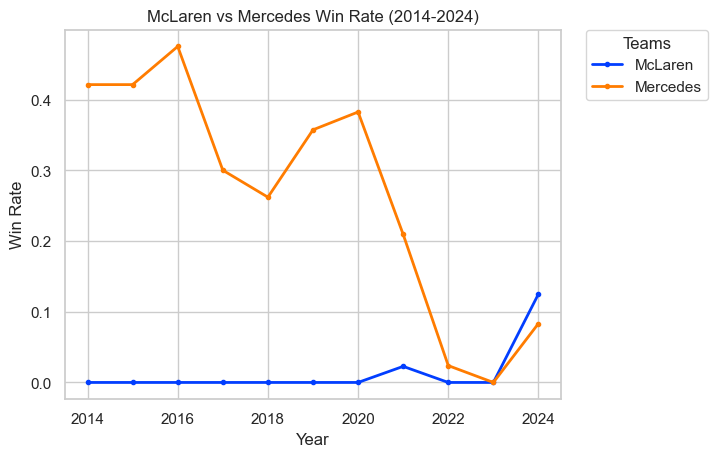

In [195]:
for team in key_teams:
    team_data = yearly_performance[yearly_performance['CONSTRUCTOR_NAME'] == team]
    plt.plot(team_data['YEAR'], team_data['WIN_RATE'], marker='.', linewidth=2, label=team)

plt.title(f'McLaren vs Mercedes Win Rate ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('Win Rate')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [196]:
championships = yearly_performance.groupby('YEAR').apply(
    lambda x: x.sort_values('POINTS', ascending=False)['CONSTRUCTOR_NAME'].reset_index(drop=True)
).unstack()
styled = championships.style.set_caption('Team Championship Positions by Year') \
    .set_properties(**{'text-align': 'center'}) \
    .set_table_styles([{
        'selector': 'th',
        'props': [('text-align', 'center')]
    }])
styled


C:\Users\emily.nagle\AppData\Local\Temp\ipykernel_32332\660181147.py:1: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,0,1,2,3,4,5,6,7,8,9,10
YEAR,,,,,,,,,,,
2014,Mercedes,Red Bull,Williams,Ferrari,McLaren,Force India,Toro Rosso,Lotus F1,Marussia,Caterham,Sauber
2015,Mercedes,Ferrari,Williams,Red Bull,Force India,Lotus F1,Toro Rosso,Sauber,McLaren,Manor Marussia,nan
2016,Mercedes,Red Bull,Ferrari,Force India,Williams,McLaren,Toro Rosso,Haas F1 Team,Renault,Sauber,Manor Marussia
2017,Mercedes,Ferrari,Red Bull,Force India,Williams,Renault,Toro Rosso,Haas F1 Team,McLaren,Sauber,nan
2018,Mercedes,Ferrari,Red Bull,Renault,Force India,Haas F1 Team,McLaren,Sauber,Toro Rosso,Williams,nan
2019,Mercedes,Ferrari,Red Bull,McLaren,Renault,Toro Rosso,Racing Point,Alfa Romeo,Haas F1 Team,Williams,nan
2020,Mercedes,Red Bull,Racing Point,McLaren,Renault,Ferrari,AlphaTauri,Alfa Romeo,Haas F1 Team,Williams,nan
2021,Mercedes,Red Bull,Ferrari,McLaren,Alpine F1 Team,AlphaTauri,Aston Martin,Williams,Alfa Romeo,Haas F1 Team,nan
2022,Red Bull,Ferrari,Mercedes,Alpine F1 Team,McLaren,Aston Martin,Alfa Romeo,AlphaTauri,Haas F1 Team,Williams,nan


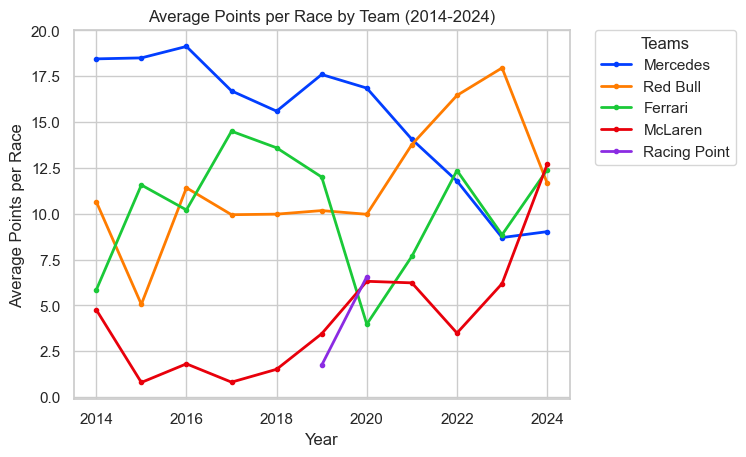

In [197]:
for team in top_teams:
    team_data = yearly_performance[yearly_performance['CONSTRUCTOR_NAME'] == team]
    plt.plot(team_data['YEAR'], team_data['AVG_POINTS'], marker='.', linewidth=2, label=team)

plt.title(f'Average Points per Race by Team ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('Average Points per Race')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

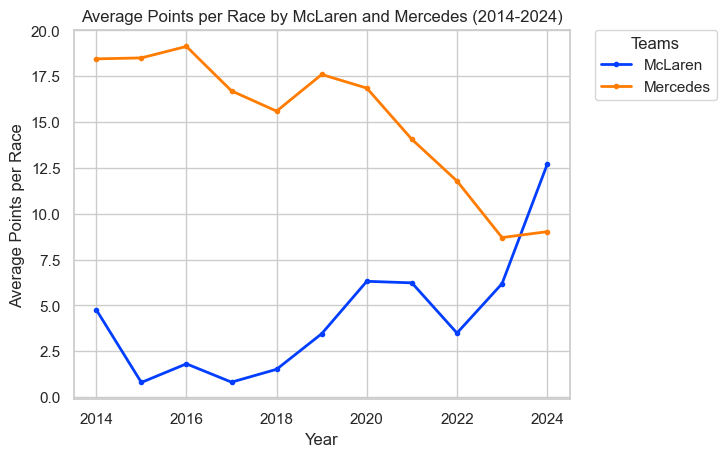

In [ ]:
for team in key_teams:
    team_data = yearly_performance[yearly_performance['CONSTRUCTOR_NAME'] == team]
    plt.plot(team_data['YEAR'], team_data['AVG_POINTS'], marker='.', linewidth=2, label=team)

plt.title(f'Average Points per Race by McLaren and Mercedes ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('Average Points per Race')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


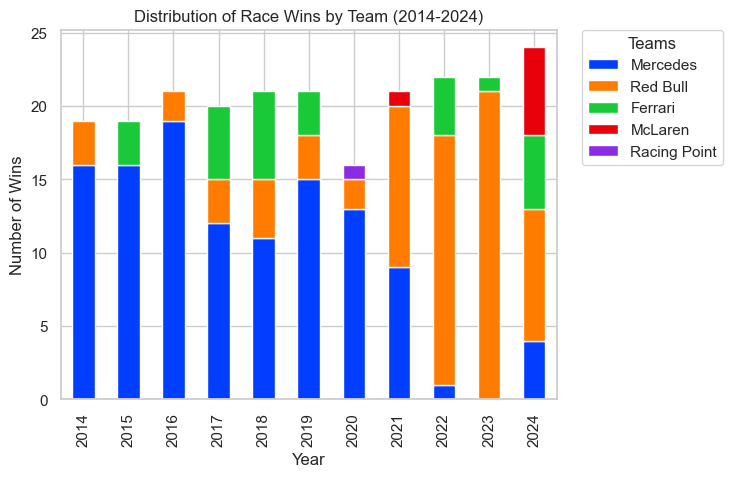

In [198]:
wins_by_year = yearly_performance.pivot_table(index='YEAR', columns='CONSTRUCTOR_NAME', values='WIN', fill_value=0)
wins_by_year[top_teams].plot(kind='bar', stacked=True)
plt.title(f'Distribution of Race Wins by Team ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('Number of Wins')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


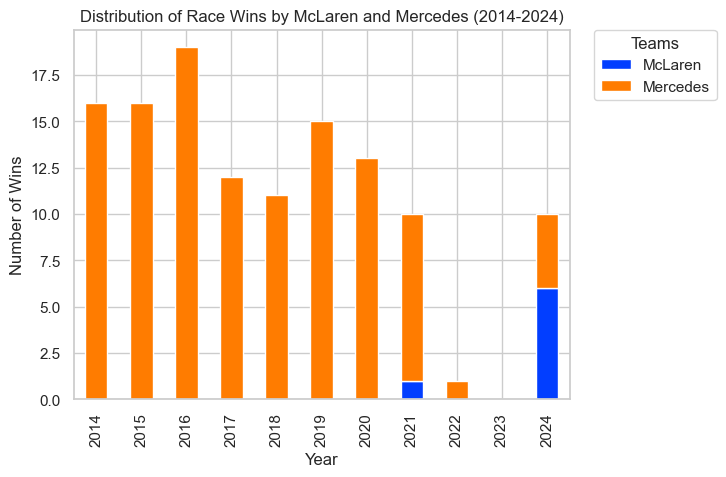

In [ ]:
wins_by_year = yearly_performance.pivot_table(index='YEAR', columns='CONSTRUCTOR_NAME', values='WIN', fill_value=0)
wins_by_year[key_teams].plot(kind='bar', stacked=True)
plt.title(f'Distribution of Race Wins by McLaren and Mercedes ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('Number of Wins')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

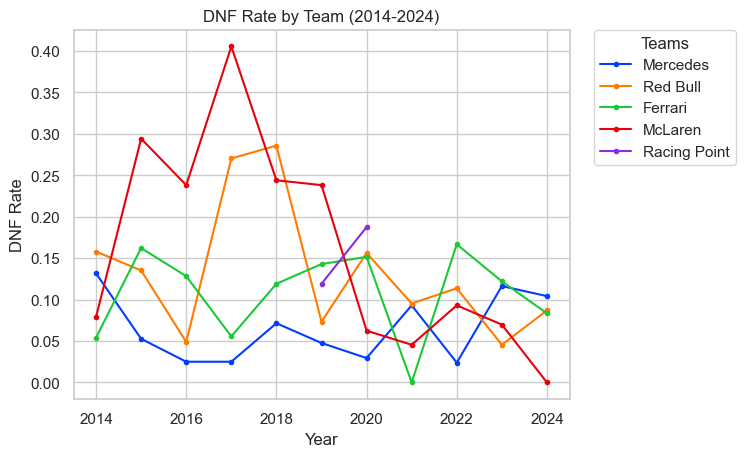

In [ ]:
for team in top_teams:
    team_data = yearly_performance[yearly_performance['CONSTRUCTOR_NAME'] == team]
    plt.plot(team_data['YEAR'], team_data['DNF_RATE'], marker='.',label=team)

plt.title(f'DNF Rate by Team ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('DNF Rate')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


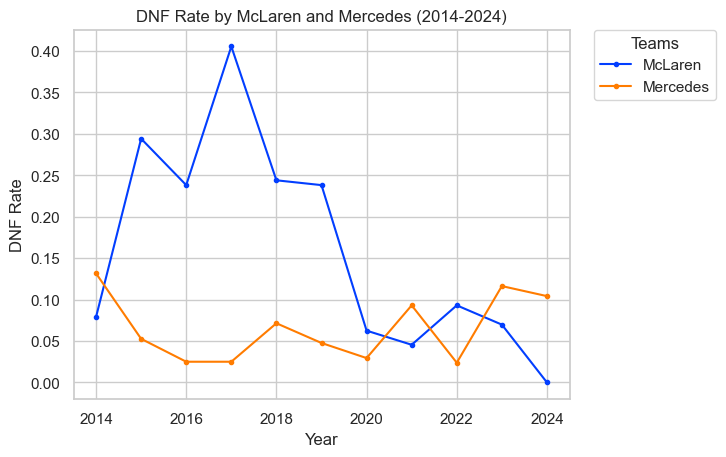

In [ ]:
for team in key_teams:
    team_data = yearly_performance[yearly_performance['CONSTRUCTOR_NAME'] == team]
    plt.plot(team_data['YEAR'], team_data['DNF_RATE'], marker='.', label=team)

plt.title(f'DNF Rate by McLaren and Mercedes ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('DNF Rate')
plt.legend(title='Teams',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

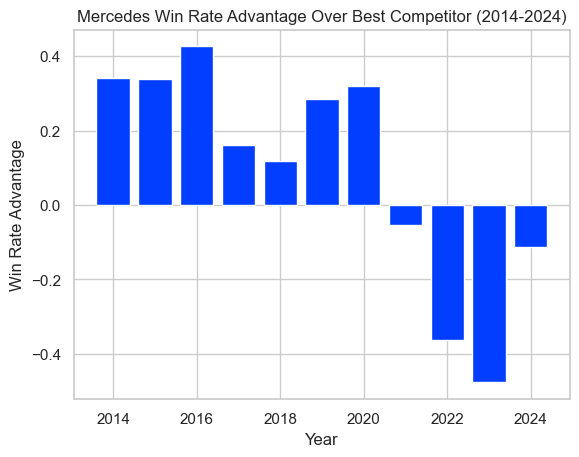

In [ ]:
mercedes_data = yearly_performance[yearly_performance['CONSTRUCTOR_NAME'] == 'Mercedes']
other_teams = yearly_performance[yearly_performance['CONSTRUCTOR_NAME'] != 'Mercedes']
other_best = other_teams.groupby('YEAR')['WIN_RATE'].max().reset_index()
other_best.columns = ['YEAR', 'BEST_COMPETITOR_WIN_RATE']

mercedes_advantage = pd.merge(
    mercedes_data[['YEAR', 'WIN_RATE']], 
    other_best,
    on='YEAR'
)
mercedes_advantage['ADVANTAGE'] = mercedes_advantage['WIN_RATE'] - mercedes_advantage['BEST_COMPETITOR_WIN_RATE']

plt.bar(mercedes_advantage['YEAR'], mercedes_advantage['ADVANTAGE'])
plt.title(f'Mercedes Win Rate Advantage Over Best Competitor ({year_boundaries})')
plt.xlabel('Year')
plt.ylabel('Win Rate Advantage')
plt.show()


#### Pole Gap Analysis

In [90]:
pole gap analysis for top teams

visualise gap distribution
relationship between pole gap and race win %

SyntaxError: invalid syntax (3399993892.py, line 1)

#### Lap Time Analysis

In [ ]:
lap time analysis for top teams
visualise distribution
relationship between fastest lap and race win

#### Circuit Location Analysis

In [ ]:
performance by circuit for Mercedes vs McLaren 0? TODO could be a good idea to just focus on these two teams

for each team:
    top 10 circuits
performance by altitude category

#### Tire Strategy/ Pit Stop Analysis

In [ ]:
#estimate pitstops
analyse mercedes + mclaren performance by estimated pit stop
visualise


### Factor Analysis using Machine Learning

#### Prepare Data for Modelling

In [ ]:
focus on mercedes and McLaren
define features and target -> pole gap, grid, fastest lap sec, fastest lap speed, circuit name, country, alt category
handle missing vals
categorical variables encode -> circuit name, country, alt category
split data etc. etc.

#### Model 1 - Random Forest Model

#### Model 2 - Logistic Regression for Interpretability

#### Model 3 - Gradient Boosting Classifier

#### Model 4 - Support Vector Machine

#### Model 5 - Neural Network

### Model Comparison

#### 3. Circuit Location Analysis

# Key Findings and Insights

#### 1. Pole Gap Analysis

####  2. Lap Time Analysis

####  3. Circuit Location Analysis

####  4. Machine Learning Factor Analysis

# Recommendations and Conclusion